# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

In [ ]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Mounted at /content/drive


In [ ]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [ ]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


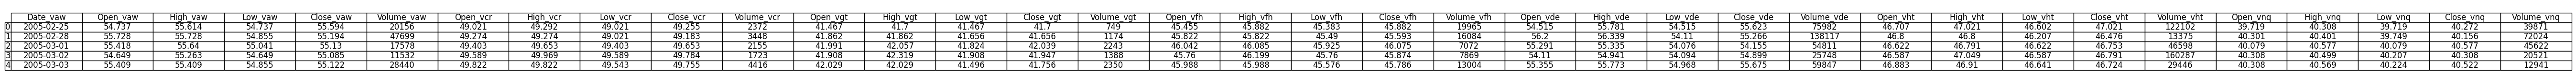

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Step 2: Create or load a DataFrame


# Step 3: Use matplotlib to create an image of the .head() output
df_head = data.head()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2)) # Adjust the size as needed

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table plot and add it to the axes
tbl = table(ax, df_head, loc='center', cellLoc='center', colWidths=[0.2]*len(df_head.columns))

# Adjust the font size and layout
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

# Save the plot as an image file
plt.savefig('dataframe_head.png', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


In [ ]:
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = pd.to_datetime(data['Date'])
data.pop('Date')

Train = data[:2240]
Validation = data[2240:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(Validation.shape)

(2240, 35)
(641, 35)
(320, 35)


In [ ]:
plt.plot(data.index, data['Close_vaw'], label='vaw')
plt.plot(data.index, data['Close_vcr'], label='vcr')
plt.plot(data.index, data['Close_vht'], label='vht')
plt.plot(data.index, data['Close_vgt'], label='vgt')
plt.plot(data.index, data['Close_vfh'], label='vfh')
plt.plot(data.index, data['Close_vde'], label='vde')
plt.plot(data.index, data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values of the ETFs')
plt.legend()
plt.show()

In [ ]:

# Compute mean and std of the training set
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1  # Prevent division by zero

# Normalize training data
Train_normalized = (Train - mean) / std

# Normalize training data
Validation_normalized = (Validation - mean) / std

# Normalize test data
Test_normalized = (Test - mean) / std

In [ ]:
#mode_list = ['multi', 'single']
#mode_param = ['multi', 'single']


In [ ]:
multi_stock = True
multi_column = False  #if false only use closing price else: open,high,low,close,volume

ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']
if(not multi_stock):
  ETF_active = ETF[3]

fragment_size = 10    #number of days in each fragment
step = 1    #days of separation between fragments

if (multi_column):
  if (multi_stock):
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized .iloc[i:i + fragment_size] for i in range(0, len(Validation_normalized ) - fragment_size, step)]
    Validation_Labels = [Validation_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Validation_normalized ), step)]

    Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
  else:
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Validation_normalized) - fragment_size, step)]
    Validation_Labels = [Validation_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Validation_normalized), step)]

    Test_Fragmented = [Test_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]
else:
  if (multi_stock):
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized.iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Validation_normalized) - fragment_size, step)]
    Validation_Labels = [Validation_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Validation_normalized), step)]

    Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
  else:
    Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
    Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

    Validation_Fragmented = [Validation_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Validation_normalized) - fragment_size, step)]
    Validation_Labels = [Validation_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Validation_normalized), step)]

    Test_Fragmented = [Test_normalized.iloc[i:i + fragment_size][['Close_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
    Test_Labels = [Test_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]


In [ ]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Validation Fragments: {len(Validation_Fragmented)}')
print(f'Number of Validation Labels: {len(Validation_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


In [ ]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_validation = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Validation_Fragmented]
X_Validation = torch.stack(tensor_list_validation)
label_tensor_list_validation = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Validation_Labels]
Y_Validation =  torch.stack(label_tensor_list_validation)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train, Y_train, X_test, Y_test are already defined and normalized
X_train_pt = X_train.float().to(device)
Y_train_pt = Y_train.float().to(device)
X_Validation_pt = X_Validation.float().to(device)
Y_Validation_pt = Y_Validation.float().to(device)
X_test_pt = X_test.float().to(device)
Y_test_pt = Y_test.float().to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_pt, Y_train_pt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
class Simple_LSTM(nn.Module):
    def __init__(self,
                 input_size: int = 5,
                 hidden_size: int = 64,
                 output_size: int = 1,
                 num_layers: int = 5,
                 dropout_prob: float = 0.05
                 ):
        super().__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(p=dropout_prob)

        self.last_linear = nn.Linear(hidden_size, output_size)


        #self.batchnorm = nn.BatchNorm1d(hidden_size)   gave us some errors so we didn't use it.
    def forward(self, X):
        _, last_states = self.lstm(X)
        last_hidden_state = last_states[0][-1, :, :]
        # Applying dropout and batch normalization
        last_hidden_state = self.dropout(last_hidden_state)
        #last_hidden_state = self.batchnorm(last_hidden_state)


        next_prediction = self.last_linear(last_hidden_state)
        return next_prediction


In [ ]:
class Conv_LSTM(nn.Module):
    def __init__(self,
                 conv_filters: int=128,
                 conv_kernel_size: int=1,
                 input_size: int=35,
                 hidden_size: int=64,
                 output_size: int=7,
                 dropout_prob: int =0.05,
                 num_layers: int=1
                ):
        super(Conv_LSTM, self).__init__()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=conv_kernel_size, stride=1, padding='same')
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.last_linear = nn.Linear(hidden_size, output_size)
        self.avgpool = nn.AvgPool1d(1)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.batchnorm = nn.BatchNorm1d(hidden_size)

    def forward(self, X):
        # Assuming X has dimensions [batch_size, sequence_length, num_features]
        x = self.conv(X.permute(0, 2, 1))  # Permute to [batch_size, num_features, sequence_length]
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.relu(x)
        _, (x, _) = self.lstm(x.permute(0, 2, 1))
        x = x[-1, :, :]
        #x = self.batchnorm(x)  # Add batch normalization
        x = self.dropout(x)  # Add dropout
        x = self.last_linear(x)
        return x


In [ ]:
def train_and_validation_loop(model, loss_func, optimizer, train_loader, X_Validation, Y_Validation ,num_epochs = 100):
  # Training loop
  loss_its = []

  for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0.0

      # Iterate over batches in the DataLoader
      for batch_X, batch_Y in train_loader:
          optimizer.zero_grad()

          # Move batch data to the device
          batch_X = batch_X.to(device)
          batch_Y = batch_Y.to(device)

          # Forward pass
          output = model(batch_X)

          # Compute loss
          loss = loss_func(output, batch_Y)
          epoch_loss += loss.item()

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

      # Compute average loss for the epoch
      epoch_loss /= len(train_loader)
      loss_its.append(epoch_loss)

      # Print epoch statistics
      if epoch % 5 == 0:
          output_test = model(X_test_pt)
          test_loss = loss_func(output_test, Y_test_pt)
          print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')

  print(f'Epoch [{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')
  print('Training complete.')

  model.eval()
  with torch.no_grad():
    output = model(X_Validation)
    val_loss = loss_func(output,Y_Validation)
  print(val_loss)
  return val_loss.item()




In [ ]:
cnn = True

In [ ]:




if (multi_column):
  if (multi_stock):
    if(cnn):
      param_grid = {
        'input_size': [35],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0],
        'conv_kernel_size':[1,3,5],
        'conv_filters' : [64,128]
        }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [35],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
        }
      num_epoch = 50
  else:
    if(cnn):
      param_grid = {
        'input_size': [5],
        'hidden_size': [20, 50, 200, 1000],
        'output_size': [1],
        'num_layers': [1,4],
        'dropout': [0.0],
        'conv_kernel_size':[1,4],
        'conv_filters' : [64,128]
        }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [5],
        'hidden_size': [20, 50],
        'output_size': [1],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
    }
      num_epoch = 50
else:
  if (multi_stock):
    if(cnn):
      param_grid = {
        'input_size': [7],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0],
        'conv_kernel_size':[1,3,5],
        'conv_filters' : [64,128]
        }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [7],
        'hidden_size': [20, 50],
        'output_size': [7],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
    }
      num_epoch = 50
  else:
    if(cnn):
      param_grid = {
          'input_size': [1],
          'hidden_size': [20, 50],
          'output_size': [1],
          'num_layers': [1, 3, 5],
          'dropout': [0.0],
          'conv_kernel_size':[1,3,5],
          'conv_filters' : [64,128]
          }
      num_epoch = 50
    else:
      param_grid = {
        'input_size': [1],
        'hidden_size': [20, 50],
        'output_size': [1],
        'num_layers': [1, 3, 5],
        'dropout': [0.0]
    }
      num_epoch = 50

# Define model, loss function, and optimizer

loss_func = nn.MSELoss()

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

best_params = None
best_val_loss = float('inf')
for params in ParameterGrid(param_grid):
    if(cnn):
      model = Conv_LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], output_size = params['output_size'], num_layers=params['num_layers'], dropout_prob = params['dropout'],conv_filters = params['conv_filters'],conv_kernel_size = params['conv_kernel_size'] ).cuda()
      print(f'Hidden Size: {params["hidden_size"]}, Num Layers: {params["num_layers"]}, Dropout Probability: {params["dropout"]},conv_filters: {params["conv_filters"]}, kernel:{params["conv_kernel_size"]}')
    else:
      print(f'Hidden Size: {params["hidden_size"]}, Num Layers: {params["num_layers"]}, Dropout Probability: {params["dropout"]}')
      model = Simple_LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], output_size = params['output_size'], num_layers=params['num_layers'], dropout_prob = params['dropout']).cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    val_loss = train_and_validation_loop(model, loss_func, optimizer, train_loader, X_Validation_pt, Y_Validation_pt, num_epochs = num_epoch)
    print(f'Validation Loss: {val_loss}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model

print(f'Best Params:  [Hidden Size: {best_params["hidden_size"]}, Num Layers: {best_params["num_layers"]}, Dropout Probability: {best_params["dropout"]}]')

if(cnn):
  print(f'Best Params:  [Hidden Size: {best_params["hidden_size"]}, Num Layers: {best_params["num_layers"]}, Dropout Probability: {best_params["dropout"]}, Kernel Size:{best_params["conv_kernel_size"]}, Convolution Filters :{best_params["conv_filters"]} ]')



In [ ]:
#torch.save(best_model, '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/models/multi_multi.pth')



In [ ]:
best_model = torch.load('/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/models/CNN_multi_single.pth')

In [ ]:


if(cnn):
  print(f'Best Params:  [Hidden Size: {best_params["hidden_size"]}, Num Layers: {best_params["num_layers"]}, Dropout Probability: {best_params["dropout"]}, Kernel Size:{best_params["conv_kernel_size"]}, Convolution Filters :{best_params["conv_filters"]} ]')

# Histogram

In [ ]:
# Plot for Y_predicted and Y

def plot_results(Y_squeezed, Y_predicted,index, title = 'Test sample forecast of vaw', random_color = False):

    # Plot Y
    plt.figure(figsize=(12, 8))
    if Y_squeezed.ndim == 1:
      plt.plot(index,Y_squeezed[:], label=f"Actual Signal {1}")
    elif Y_squeezed.ndim == 2:
      for i in range(Y_squeezed.shape[1]): #for i in range(1):
        if(random_color):
          plt.plot(index,Y_squeezed[:, i], label=f"Actual Signal {i+1}")
        else:
          plt.plot(index,Y_squeezed[:, i], label=f"Actual Signal {i+1}", color=f'C{i}')

    # Plot Y_predicted
    if Y_predicted.shape[1] == 1:
        plt.plot(index,Y_predicted, label="Predicted Signal", linestyle='--')
    elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
        for i in range(Y_predicted.shape[1]): #for i in range(1):
          if(random_color):
            plt.plot(index,Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")
          else:
            plt.plot(index,Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}", color=f'C{i}')

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [ ]:
#Print Train



if (multi_stock):
  STD = std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  STD = STD.to_numpy()
  STD.reshape((-1,1))
  MEAN = mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  MEAN = MEAN.to_numpy()
  MEAN.reshape((-1,1))
  Y_train = Train_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] * std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] + mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
  Y_test = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] * std[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] + mean[['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  STD = std[['Close_'  + ETF_active]]
  STD = STD.to_numpy()
  STD.reshape((-1,1))
  MEAN = mean[['Close_'  + ETF_active]]
  MEAN = MEAN.to_numpy()
  MEAN.reshape((-1,1))
  Y_train = Train_normalized[fragment_size:][['Close_'  + ETF_active]] * std[['Close_'  + ETF_active]] + mean[['Close_'  + ETF_active]]
  Y_test = Test_normalized[fragment_size:][['Close_'  + ETF_active]] * std[['Close_'  + ETF_active]] + mean[['Close_'  + ETF_active]]

Y_predicted_train = best_model(X_train_pt).cpu().detach().numpy() * STD.T + MEAN.T
Y_predicted_test = best_model(X_test_pt).cpu().detach().numpy() * STD.T + MEAN.T

Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()




In [ ]:
dummy_prediction = X_test[:, -1:, :].cpu().detach().numpy() * STD.T + MEAN.T

print(dummy_prediction.shape)

In [ ]:

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_train_np.squeeze()
Y_predicted = Y_predicted_train
plot_results(Y_squeezed, Y_predicted,Y_train.index, 'Train sample forecast of vaw', random_color = True)

In [ ]:
# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_test_np.squeeze()
Y_predicted = Y_predicted_test
plot_results(Y_squeezed, Y_predicted,Y_test.index, 'Test sample forecast of CNN_LSTM multiple stock single variable')

In [ ]:
# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_test[:10].squeeze()
Y_predicted = Y_predicted_test[:10]
plot_results(Y_squeezed, Y_predicted,Y_test.index[:10] ,'Test sample forecast of vaw LSTM 256hs batched data loader')

In [ ]:
mse = np.mean((Y_squeezed - Y_predicted) ** 2)
print("Mean Squared Error:", mse)